In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import os
import errno
import utils

import CGDs
import importlib
importlib.reload(CGDs)


from pyDOE import lhs
from torch import from_numpy

import torch
import torch.cuda
import torch.nn as nn
import torch.optim as optim
import torch.autograd as tgrad

# Manage device

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
# torch.set_default_tensor_type(torch.DoubleTensor)
print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

True
cuda


# Data Sampling

In [3]:
samples = {"pde": 10000, "bc":5000, "fc":5000}

K = 40.0
r = 0.05
sigma = 0.25
T = 1.0
S_range = [0.0, 130.0]
t_range = [0.0, T]
gs = lambda x: np.fmax(x-K, 0.0)

# Build Neural Network

In [4]:
import networks
# Create the model
PINNCGD = networks.FeedforwardNeuralNetwork(2, 50, 1, 3)
PINNCGD.to(device)
print(PINNCGD)

FeedforwardNeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1-2): 2 x Linear(in_features=50, out_features=50, bias=True)
  )
  (output): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
)


In [5]:
D_CGD = networks.Discriminator(2, 25, 4)
D_CGD.to(device)
D_CGD.load_state_dict(D_CGD.state_dict()) # copy weights and stuff
print(D_CGD)

Discriminator(
  (map): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): ReLU()
    (8): Linear(in_features=50, out_features=4, bias=True)
  )
)


# Network Trainig

### Hyperparameters

In [6]:
max_iter = 30000

tol = 1e-7
atol = 1e-20
g_iter = 1000
lr = 0.01
track_cond = lambda x, y: True


# Define loss function and optimizer
# optimizer = CGDs.BCGD(max_params=D_CGD.parameters(), min_params=PINNCGD.parameters(), device = device,
#                  lr_max=lr, lr_min=lr, tol=1e-10, collect_info=True)
# optimizer = CGDs.ACGD(max_params=D_CGD.parameters(), min_params=PINNCGD.parameters(),
#                  lr_max=lr, lr_min=lr, tol=1e-10, beta=0.99, eps=1e-8, collect_info=True)
optimizer = CGDs.GACGD(x_params=D_CGD.parameters(), y_params = PINNCGD.parameters(), max_iter = g_iter,
            lr_x=0.001, lr_y=0.01, tol=tol, atol = atol, eps=1e-8, beta=0.99, track_cond = track_cond)
lossFunction = nn.MSELoss()

### Training

In [7]:
start_time = time.time()
loss_hist = []
# dis_hist = []
for epoch in range(max_iter):
    
    optimizer.zero_grad() # zeroes the gradient buffers of all parameters
    
    # normal condition / interior points
    n_st_train = np.concatenate([np.random.uniform(*t_range, (samples['pde'], 1)), 
                      np.random.uniform(*S_range, (samples['pde'], 1))], axis=1)
    n_v_train = np.zeros((samples['pde'], 1))
    

    # final condition (t = T, S is randomized)
    f_st_train = np.concatenate([np.ones((samples['fc'], 1)),
                    np.random.uniform(*S_range, (samples['fc'], 1))], axis=1)
    f_v_train = gs(f_st_train[:, 1]).reshape(-1, 1)
    
    # lower boundary condition (S = 0, t is randomized)
    lb_st = np.concatenate([np.random.uniform(*t_range, (samples['bc'], 1)),
                        0 * np.ones((samples['bc'], 1))], axis=1)
    lb_v = np.zeros((samples['bc'], 1))
    
    # upper boundary condition (S = Smax, t is randomized)
    ub_st = np.concatenate([np.random.uniform(*t_range, (samples['bc'], 1)), 
                        S_range[-1] * np.ones((samples['bc'], 1))], axis=1)
    ub_v = (S_range[-1] - K*np.exp(-r*(T-ub_st[:, 0].reshape(-1)))).reshape(-1, 1)
    
    
    
    
    
    # save training data points to tensor and send to device
    n_st_train = torch.from_numpy(n_st_train).float().requires_grad_().to(device)
    n_v_train = torch.from_numpy(f_v_train).float().to(device)
    
    f_st_train = torch.from_numpy(f_st_train).float().to(device)
    f_v_train = torch.from_numpy(f_v_train).float().to(device)
    
    lb_st = torch.from_numpy(lb_st).float().to(device)
    lb_v = torch.from_numpy(lb_v).float().to(device)
    
    ub_st = torch.from_numpy(ub_st).float().to(device)
    ub_v = torch.from_numpy(ub_v).float().to(device)
    
    
    
    
    
    # prediction
    v1_hat = PINNCGD(n_st_train)
    
    grads = tgrad.grad(v1_hat, n_st_train, grad_outputs=torch.ones(v1_hat.shape).cuda(), 
                       retain_graph=True, create_graph=True, only_inputs=True)[0]
    dVdt, dVdS = grads[:, 0].view(-1, 1), grads[:, 1].view(-1, 1)
    grads2nd = tgrad.grad(dVdS, n_st_train, grad_outputs=torch.ones(dVdS.shape).cuda(),
                          create_graph=True, only_inputs=True)[0]
    d2VdS2 = grads2nd[:, 1].view(-1, 1)
    S1 = n_st_train[:, 1].view(-1, 1)
    
    f_hat = PINNCGD(f_st_train)
    lb_hat = PINNCGD(lb_st)
    ub_hat = PINNCGD(ub_st)
    
    
    # combined loss
    d1 = D_CGD(n_st_train)[:, [0]]
    loss1 = ((d1) * (dVdt + 0.5*((sigma*S1)**2)*d2VdS2 + r*S1*dVdS - r*v1_hat))
    
    d2 = D_CGD(f_st_train)[:, [1]]
    loss2 = ((d2) * (f_hat - f_v_train))
    
    d3 = D_CGD(lb_st)[:, [2]]
    loss3 = ((d3) * (lb_hat - lb_v))
    
    d4 = D_CGD(ub_st)[:, [3]]
    loss4 = ((d4) * (ub_hat - ub_v))
    
    combined_loss = (loss1.mean() + loss2.mean() + loss3.mean() + loss4.mean())
    
    
    # boundary condition loss
    pde_loss = lossFunction(-dVdt, 0.5*((sigma*S1)**2)*d2VdS2 + r*S1*dVdS - r*v1_hat)
    
    bc_loss = lossFunction(ub_v, ub_hat) + lossFunction(lb_v, lb_hat) + lossFunction(f_v_train, f_hat)
    pinn_loss = pde_loss + bc_loss
    
    
    
    # Backpropagation and Update
    optimizer.step(combined_loss, -combined_loss)

    
    # print information
    loss_hist.append(pinn_loss.item())
    if epoch % 50 == 0:
        print(f'''{epoch}/{max_iter} mse loss: {pinn_loss.item():.6f}, 
              PDE Loss: {pde_loss.item():.6f}, BC Loss: {bc_loss.item():.6f}, 
              nn loss: {combined_loss.item():.8f}, 
              minloss: {min(loss_hist):.6f}
              ''')
        pass
        
end_time = time.time()
print('run time:', end_time - start_time)
print('finish')

c:\Users\hengr\miniconda3\envs\honor\lib\site-packages\CGDs\gmres_torch.py:124: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BatchLinearAlgebra.cpp:2197.)
  y, _ = torch.triangular_solve(beta[0:j + 1].unsqueeze(-1), H[0:j + 1, 0:j + 1])  # j x j


0/30000 mse loss: 9687.691406, 
              PDE Loss: 0.000028, BC Loss: 9687.691406, 
              nn loss: 245.78974915, 
              minloss: 9687.691406
              
50/30000 mse loss: 16.694838, 
              PDE Loss: 2.113338, BC Loss: 14.581500, 
              nn loss: 0.40101784, 
              minloss: 8.439303
              
100/30000 mse loss: 10.714383, 
              PDE Loss: 0.856960, BC Loss: 9.857423, 
              nn loss: 0.01971586, 
              minloss: 8.439303
              
150/30000 mse loss: 7.828498, 
              PDE Loss: 3.372201, BC Loss: 4.456296, 
              nn loss: -0.08646940, 
              minloss: 2.880805
              
200/30000 mse loss: 1.207664, 
              PDE Loss: 0.574182, BC Loss: 0.633482, 
              nn loss: -0.04367741, 
              minloss: 0.964447
              
250/30000 mse loss: 0.922177, 
              PDE Loss: 0.634012, BC Loss: 0.288165, 
              nn loss: -0.03758368, 
              minloss: 0.

KeyboardInterrupt: 

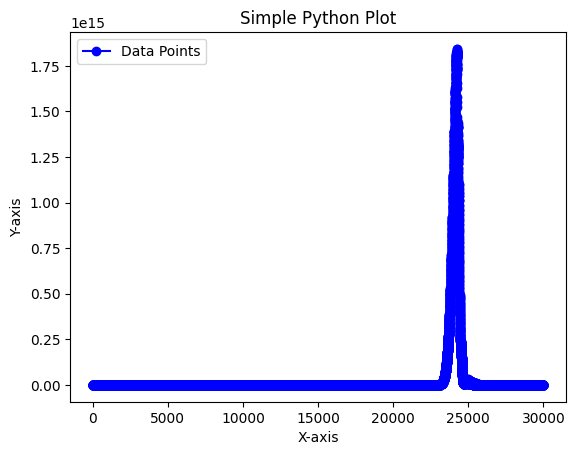

In [ ]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
ax.plot(range(30000), loss_hist, marker='o', linestyle='-', color='b', label='Data Points')

# Set labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Simple Python Plot')

# Show legend
ax.legend()

# Display the plot
plt.show()